In [1]:
import os
import sys
from collections import defaultdict
from functools import reduce, partial
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import spatial
import tqdm

from pymutspec.annotation import mutations_summary, calculate_mutspec, lbl_id2lbl, lbl2lbl_id
from pymutspec.constants import possible_sbs192, possible_sbs12
from pymutspec.draw import plot_mutspec192, plot_mutspec12
from pymutspec.draw.sbs_orders import ordered_sbs192_kp

## Load data

### Check invar sites intersection

In [2]:
r_nd1 = pd.concat([
    pd.read_csv("../data/exposure/mammals_nd1/states/gtr.rate", comment="#", sep="\t"),
    pd.read_csv("../data/exposure/mammals_nd1/states/strsym.rate", comment="#", sep="\t"),
    pd.read_csv("../data/exposure/mammals_nd1/states/unrest.rate", comment="#", sep="\t"),
], ignore_index=True).groupby("Site").Cat.value_counts().unstack().fillna(0).astype(np.int8)

r_cytb = pd.concat([
    pd.read_csv("../data/exposure/mammals_cytb/states/gtr.rate", comment="#", sep="\t"),
    pd.read_csv("../data/exposure/mammals_cytb/states/strsym.rate", comment="#", sep="\t"),
    pd.read_csv("../data/exposure/mammals_cytb/states/unrest.rate", comment="#", sep="\t"),
], ignore_index=True).groupby("Site").Cat.value_counts().unstack().fillna(0).astype(np.int8)

#### Different model assign different cats to same sites

In [3]:
r_nd1[r_nd1.max(axis=1) < 2]

Cat,0,1,2,3,4,5,6
Site,,,,,,,
48,0,0,0,0,1,1,1
222,0,0,0,0,1,1,1
229,0,0,0,1,1,1,0
234,0,0,0,0,1,1,1
246,0,0,0,0,1,1,1
265,0,0,0,1,1,1,0
369,0,0,0,0,1,1,1
396,0,0,0,0,1,1,1
405,0,0,0,0,1,1,1


In [9]:
r_cytb[r_cytb.max(axis=1) < 2]

Cat,0,1,2,3,4,5,6
Site,,,,,,,
72,0,0,0,0,1,1,1
240,0,0,0,0,1,1,1
426,0,0,0,0,1,1,1
477,0,0,0,0,1,1,1
712,0,0,0,1,1,1,0
1096,0,0,1,1,1,0,0


#### But invariable sites are same for each model

In [7]:
r_nd1[r_nd1[0] > 0][0].value_counts()

3    181
Name: 0, dtype: int64

In [8]:
r_cytb[r_cytb[0] > 0][0].value_counts()

3    267
Name: 0, dtype: int64

### Load rates and cats

In [2]:
dtypes_rate = {"Site": np.int16, "Cat": np.int8}

rate_nd1 = pd.read_csv("../data/exposure/mammals_nd1/states/gtr.rate", comment="#", sep="\t", dtype=dtypes_rate)
rate_cytb = pd.read_csv("../data/exposure/mammals_cytb/states/gtr.rate", comment="#", sep="\t", dtype=dtypes_rate)
rate_cytb.head()

,Site,Rate,Cat,C_Rate
0,1,0.00187,0,0.00000
1,2,0.00003,0,0.00000
2,3,0.01569,1,0.01569
3,4,0.19571,2,0.12291
4,5,0.37341,3,0.37341


### Load observed mutations

In [3]:
dtypes = dict(
    Mut=str,
    Label=np.int8, 
    PosInGene=np.int16,
    ProbaMut=np.float32, 
    ProbaFull=np.float32,
    RefNode=str,
    AltNode=str,
)
usecols = list(dtypes.keys())
usecols_simple = [x for x in usecols if not x.startswith("Proba")]

In [4]:
PATH_TO_DATA = "../data/exposure/mammals_nd1/"
mut_nd1 = pd.concat([
    # pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_simple/mutations.tsv"), dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="strsym_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_simple/mutations.tsv"), dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="unrest_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_simple/mutations.tsv"), dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="gtr_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_proba/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="unrest"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY6.8a_proba/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="RY6.8a"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY8.8_proba/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="RY8.8"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_proba/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="strsym"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_proba/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="gtr"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "pastml/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="pastml"),
], ignore_index=True).fillna(value=dict(ProbaMut=1., ProbaRef=1., ProbaFull=1.))

mut_nd1["MutBase"] = mut_nd1["Mut"].str.slice(2, 5).astype("category")


PATH_TO_DATA = "../data/exposure/mammals_cytb/"
mut_cytb = pd.concat([
    # pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_simple/mutations.tsv"), dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="strsym_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_simple/mutations.tsv"), dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="unrest_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_simple/mutations.tsv"), dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="gtr_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_proba/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="unrest_proba"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY6.8a_proba/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="RY6.8a"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY8.8_proba/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="RY8.8"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_proba/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="strsym"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_proba/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="gtr"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "pastml/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="pastml"),
], ignore_index=True).fillna(value=dict(ProbaMut=1., ProbaRef=1., ProbaFull=1.))

mut_cytb["MutBase"] = mut_cytb["Mut"].str.slice(2, 5).astype("category")

mut_nd1 = mut_nd1[mut_nd1.RefNode != "ROOT"]
mut_cytb = mut_cytb[mut_cytb.RefNode != "ROOT"]

mut_nd1 = mut_nd1.merge(rate_nd1[["Site", "Cat"]].rename(columns={"Site": "PosInGene"}), on="PosInGene")
mut_cytb = mut_cytb.merge(rate_cytb[["Site", "Cat"]].rename(columns={"Site": "PosInGene"}), on="PosInGene")

In [5]:
mut_cytb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2993469 entries, 0 to 2993468
Data columns (total 10 columns):
 #   Column     Dtype   
---  ------     -----   
 0   Mut        object  
 1   Label      int8    
 2   PosInGene  int16   
 3   ProbaMut   float32 
 4   ProbaFull  float32 
 5   RefNode    object  
 6   AltNode    object  
 7   Aproach    object  
 8   MutBase    category
 9   Cat        int8    
dtypes: category(1), float32(2), int16(1), int8(2), object(4)
memory usage: 151.3+ MB


### Load expected mutations freqs

In [7]:
dtypes_exp = dict(
    Mut=str,
    Label=str, 
    Pos=np.int16,
    Proba=np.float32, 
    Node=str,
)
usecols_exp = list(dtypes_exp.keys())
usecols_exp_simple = [x for x in usecols_exp if not x.startswith("Proba")]

PATH_TO_DATA = "../data/exposure/mammals_cytb/"
exp_cytb = pd.concat([
    # pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_simple/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="strsym_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_simple/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="unrest_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_simple/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="gtr_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_proba/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="unrest_proba"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY6.8a_proba/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="RY6.8a"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY8.8_proba/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="RY8.8"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_proba/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="strsym"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_proba/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="gtr"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "pastml/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="pastml"),
], ignore_index=True).fillna(value=dict(Proba=1.))



PATH_TO_DATA = "../data/exposure/mammals_nd1/"
exp_nd1 = pd.concat([
    # pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_simple/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="strsym_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_simple/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="unrest_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_simple/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="gtr_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_proba/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="unrest_proba"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY6.8a_proba/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="RY6.8a"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY8.8_proba/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="RY8.8"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_proba/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="strsym"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_proba/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="gtr"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "pastml/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="pastml"),
], ignore_index=True).fillna(value=dict(Proba=1.))

exp_nd1 = exp_nd1[(exp_nd1.Mut.isin(possible_sbs192)) & (exp_nd1.Node != "ROOT")]
exp_cytb = exp_cytb[(exp_cytb.Mut.isin(possible_sbs192)) & (exp_cytb.Node != "ROOT")]

exp_nd1["Cat"] = exp_nd1.Pos.map(rate_nd1.set_index("Site").Cat.to_dict()).astype(np.int8)
exp_cytb["Cat"] = exp_cytb.Pos.map(rate_cytb.set_index("Site").Cat.to_dict()).astype(np.int8)

In [8]:
exp_cytb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51107288 entries, 20708 to 55178420
Data columns (total 7 columns):
 #   Column   Dtype  
---  ------   -----  
 0   Pos      int16  
 1   Mut      object 
 2   Label    object 
 3   Proba    float32
 4   Node     object 
 5   Aproach  object 
 6   Cat      int8   
dtypes: float32(1), int16(1), int8(1), object(4)
memory usage: 2.2+ GB


### How many mutations with diffrent types observed?

In [9]:
mutations_summary(mut_cytb, "Aproach", "ProbaFull").astype(int)

,non-syn,syn,syn4f,Stop loss,Stop gain,Stop to stop
Aproach,,,,,,
gtr_proba,9141,122471,66058,25,22,0
gtr_simple,10356,82535,41547,4,3,0
pastml,10147,135584,62552,39,37,0
strsym_proba,9927,86666,43811,14,13,0
strsym_simple,10063,80472,40524,2,2,0
unrest_proba,9394,118980,65229,28,22,0
unrest_simple,9793,89686,49024,5,6,0


In [10]:
mutations_summary(mut_cytb[mut_cytb.ProbaFull > 0.3], "Aproach", "ProbaFull").astype(int)

,non-syn,syn,syn4f,Stop loss,Stop gain
Aproach,,,,,
gtr_proba,6125,59748,28901,1,1
gtr_simple,10356,82535,41547,4,3
pastml,6458,65373,31349,1,1
strsym_proba,7753,66807,32628,1,1
strsym_simple,10063,80472,40524,2,2
unrest_proba,6291,65884,34309,2,2
unrest_simple,9793,89686,49024,5,6


In [13]:
mutations_summary(mut_nd1, "Aproach", "ProbaFull").astype(int)

,non-syn,syn,syn4f,Stop loss,Stop gain
Aproach,,,,,
gtr_proba,7265,100689,57338,5,3
gtr_simple,8347,67617,35585,7,4
pastml,8074,109884,53672,6,3
strsym_proba,7940,72442,37375,1,2
strsym_simple,8101,66189,34596,0,2
unrest_proba,7437,96853,55750,5,2
unrest_simple,7987,71743,39818,6,2


In [12]:
mutations_summary(mut_nd1[mut_nd1.ProbaFull > 0.3], "Aproach", "ProbaFull").astype(int)

,non-syn,syn,syn4f,Stop loss,Stop gain
Aproach,,,,,
gtr_proba,4742,49404,25247,0,1
gtr_simple,8347,67617,35585,7,4
pastml,5084,53083,26767,1,1
strsym_proba,6112,54923,28244,0,1
strsym_simple,8101,66189,34596,0,2
unrest_proba,4884,52505,27841,1,0
unrest_simple,7987,71743,39818,6,2


**Probability distribution of mutations**

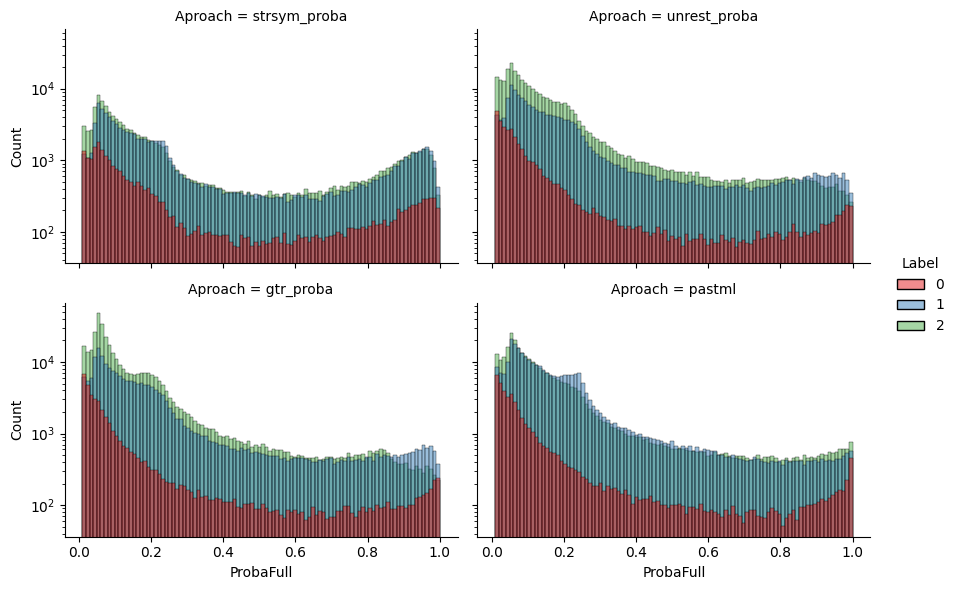

In [36]:
sns.displot(
    data=mut_nd1[(mut_nd1.Label >= 0) & (~mut_nd1.Aproach.str.contains("simple")) & (mut_nd1.ProbaFull > 0.01)], 
    x="ProbaFull", hue="Label", col="Aproach", col_wrap=2,
    log_scale=[False, True], bins=100, palette="Set1", aspect=1.5, height=3,
)
plt.show()

**Number of mutations in tree edges**

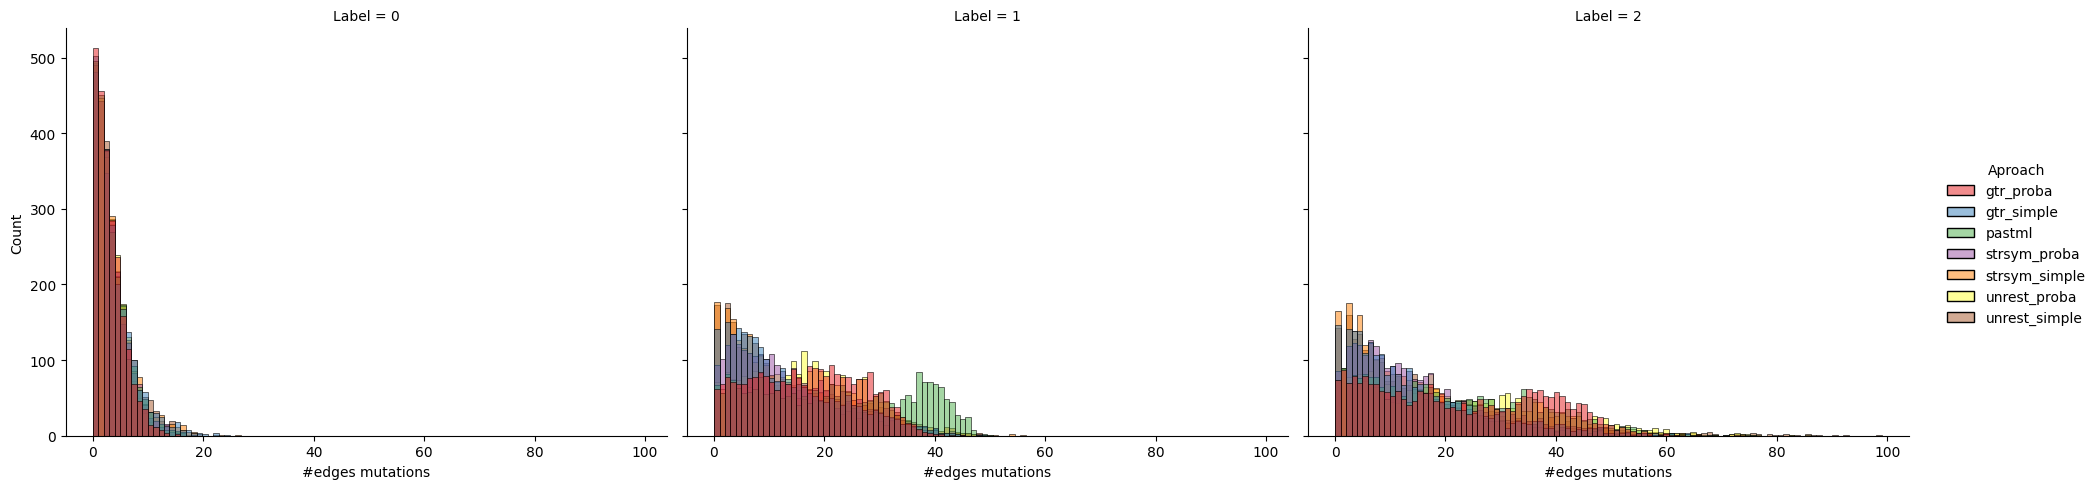

In [46]:
sns.displot(
    data=mut_nd1[mut_nd1.Label >= 0].groupby(["Aproach", "Label", "AltNode"]).ProbaFull.sum().reset_index(), 
    x="ProbaFull", col="Label", hue="Aproach", aspect=1.3, palette="Set1", bins=100,
).set_axis_labels("#edges mutations");
plt.show()

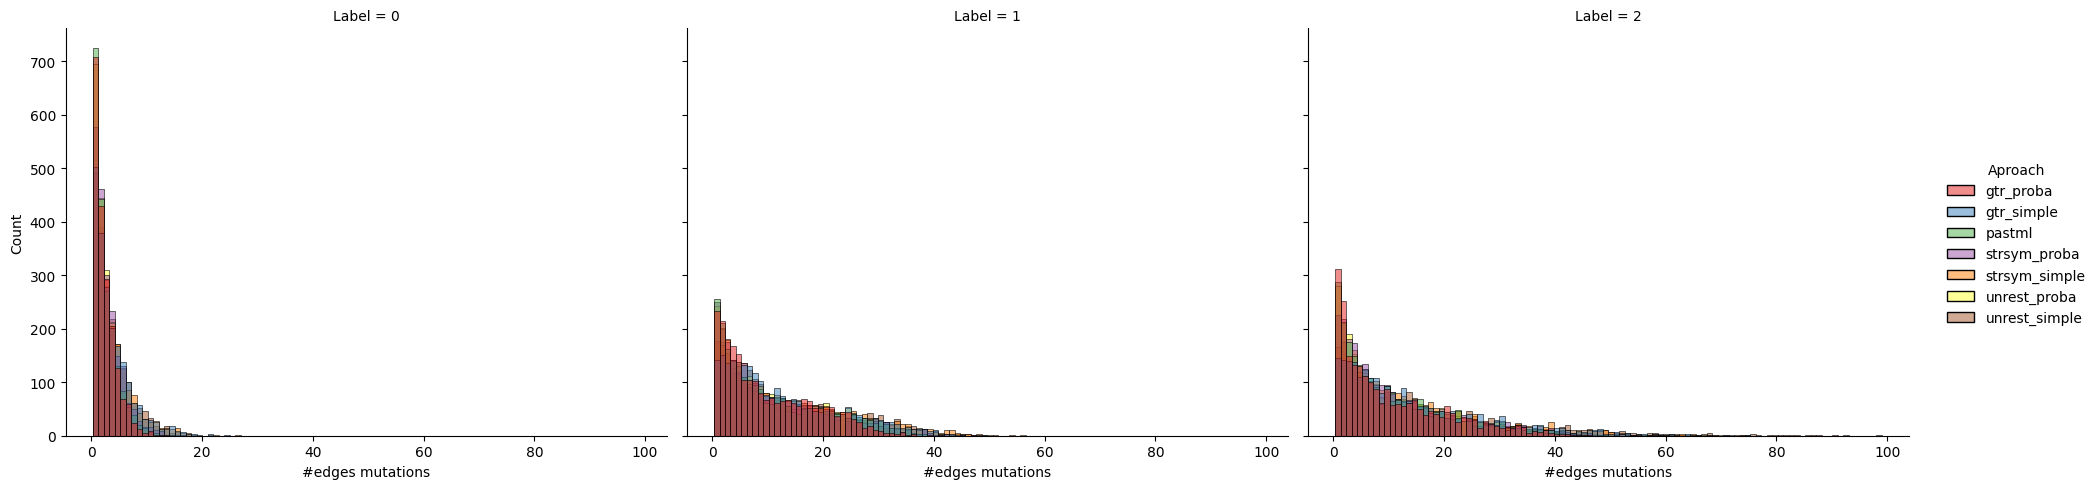

In [47]:
# after filtration (P > 0.3)
sns.displot(
    data=mut_nd1[(mut_nd1.Label >= 0) & (mut_nd1.ProbaFull > 0.3)].groupby(["Aproach", "Label", "AltNode"]).ProbaFull.sum().reset_index(), 
    x="ProbaFull", col="Label", hue="Aproach", aspect=1.3, palette="Set1", facet_kws=dict(sharex=False), bins=100,
).set_axis_labels("#edges mutations");
plt.show()

## Calculate freqs

In [9]:
exp_nd1.groupby(["Aproach", "Label", "Cat"]).Proba.sum().unstack().fillna(0).astype(int)

Cat                 1       2       3       4       5       6
Aproach Label                                                
RY6.8a  all    802723  310069  226373  294041  700056  582178
        syn      1662    1518    3076   48088  313286  525974
        syn4f     573       0       0    7258  152833  497880
        syn_c    3841    4555    9230  129747  634191  582162
RY8.8   all    797266  307879  224394  289929  694213  577824
        syn      1674    1516    3070   47339  310619  521580
        syn4f     592       0       0    6850  150917  493464
        syn_c    3839    4549    9210  128318  630023  577811
gtr     all    797105  307804  224373  289744  694051  577647
        syn      1674    1516    3069   47355  310823  521801
        syn4f     591       0       0    6905  151262  493883
        syn_c    3839    4548    9207  128254  629945  577635
pastml  all    826735  319640  232889  299898  719708  598988
        syn      1748    1559    3159   48339  319873  537936
        syn4f     624       0       0    6792  154067  507418
        syn_c    3994    4679    9477  131432  651487  598973
strsym  all    803447  310314  226623  294551  700821  582754
        syn      1673    1518    3072   48234  315532  529667
        syn4f     588       0       0    7546  156060  503125
        syn_c    3843    4555    9216  129609  634476  582751

In [10]:
LOW_CAT = 4

In [11]:
freqs_nd1_high_rate = exp_nd1[exp_nd1.Cat > LOW_CAT].groupby(["Aproach", "Node", "Label", "Mut"]).Proba.sum().unstack().fillna(0.)
freqs_nd1_low_rate = exp_nd1[exp_nd1.Cat <= LOW_CAT].groupby(["Aproach", "Node", "Label", "Mut"]).Proba.sum().unstack().fillna(0.)

freqs_cytb_high_rate = exp_cytb[exp_cytb.Cat > LOW_CAT].groupby(["Aproach", "Node", "Label", "Mut"]).Proba.sum().unstack().fillna(0.)
freqs_cytb_low_rate = exp_cytb[exp_cytb.Cat <= LOW_CAT].groupby(["Aproach", "Node", "Label", "Mut"]).Proba.sum().unstack().fillna(0.)

assert freqs_nd1_high_rate.shape[1] == 192
assert freqs_nd1_low_rate.shape[1] == 192
assert freqs_cytb_high_rate.shape[1] == 192
assert freqs_cytb_low_rate.shape[1] == 192

freqs_nd1_high_rate = freqs_nd1_high_rate.reset_index()
freqs_nd1_low_rate = freqs_nd1_low_rate.reset_index()
freqs_cytb_high_rate = freqs_cytb_high_rate.reset_index()
freqs_cytb_low_rate = freqs_cytb_low_rate.reset_index()

## Categorizing mutations

In [12]:
mut_cytb[mut_cytb.Label >= 0].groupby(["Aproach", "Label", "Cat"]).ProbaFull.sum().unstack().fillna(0).astype(int)

Cat              1     2     3      4      5      6
Aproach Label                                      
RY6.8a  0      588  1658  2869   2262   1663    414
        1       12    43   599   6954  37316   3804
        2        0     0     0    278  15037  33193
RY8.8   0      546  1523  2665   2331   1658    386
        1       10    35   564   7003  44860   5374
        2        0     0     0    311  17734  46514
gtr     0      547  1518  2628   2383   1694    369
        1       10    32   562   6920  43617   5270
        2        0     0     0    322  18834  46901
pastml  0      693  1795  2970   2476   1757    454
        1       14    35   738  10765  56569   4907
        2        0     0     1    361  20119  42069
strsym  0      609  1756  3041   2412   1746    359
        1       12    34   593   6693  32441   3079
        2        0     0     0    280  14463  29066

In [13]:
mut_nd1[mut_nd1.Label >= 0].groupby(["Aproach", "Label", "Cat"]).ProbaFull.sum().unstack().fillna(0).astype(int)

Cat              1     2     3     4      5      6
Aproach Label                                     
RY6.8a  0      366  1025  2044  1928   1591    505
        1        1    49   131  3304  29868   5203
        2        0     0     0   106   6511  35074
RY8.8   0      338   935  2001  1909   1583    476
        1        1    43   125  3265  33419   7502
        2        0     0     0   117   8136  48597
gtr     0      338   930  1992  1935   1610    458
        1        1    41   125  3246  32626   7309
        2        0     0     0   118   8360  48859
pastml  0      429  1167  2112  2089   1745    529
        1        1    45   152  4531  44218   7261
        2        0     0     0   138   9168  44366
strsym  0      389  1094  2254  2095   1673    431
        1        1    41   129  3144  27425   4323
        2        0     0     0   109   6242  31022

In [97]:
def __calc_tree_mutspec(mut, freqs, lbl="syn", pmin=0.0, pmax=1.0, collapse=False):
    """
    calculate tree mutspec from history files
    
    return mutspec of each edge in one table

    same output as calc_tree_mutspec2
    """
    # sample mutations
    mut = mut[mut.ProbaFull.between(pmin, pmax)]
    
    lbl_id = lbl2lbl_id(lbl)
    
    mutspec = []
    for (ref_node, alt_node), cur_mut in mut.groupby(["RefNode", "AltNode"]):
        # sample freqs
        _cur_freq_df = freqs[(freqs.Node == ref_node) & (freqs.Label == lbl)]
        cur_freq = _cur_freq_df[possible_sbs192].sum(axis=0).to_dict()

        # calculate mutspec
        ms192 = calculate_mutspec(cur_mut[cur_mut.Label >= lbl_id], cur_freq, use_context=True, use_proba=True)  # !!!!!!! FUCK
        ms192["RefNode"] = ref_node
        ms192["AltNode"] = alt_node
        ms192["Label"] = lbl
        mutspec.append(ms192)
    mutspec_df = pd.concat(mutspec)
    if collapse:
        mutspec_df = mutspec_df.groupby(["RefNode", "AltNode", "Label"]).apply(collapse_mutspec).reset_index()
    mutspec_df["MutBase"] = mutspec_df.Mut.str.slice(2, 5)
    mutspec_df["Context"] = mutspec_df.Mut.str.get(0) + mutspec_df.Mut.str.get(2) + mutspec_df.Mut.str.get(-1)
    return mutspec_df

In [14]:
def calc_tree_mutspec2(mut:pd.DataFrame, freqs, lbl="syn", pmin=0.0, pmax=1.0, collapse=False):
    mut = mut[
        (mut.Label >= lbl2lbl_id(lbl)) & 
        (mut.ProbaFull.between(pmin, pmax, "right"))
    ]
    # print("#mutations:", mut.ProbaFull.sum())
    if mut.ProbaFull.sum() < 100:
        return None
    mut = mut.groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum().unstack()
    assert len(mut) > 0

    for sbs192 in set(possible_sbs192).difference(mut.columns):
        mut[sbs192] = 0.0
            
    mut = mut[possible_sbs192]
    freqs = freqs[freqs.Label == lbl]
    edges_df = mut.index.to_frame(False)

    freqs = edges_df.merge(freqs, left_on="RefNode", right_on="Node")\
        .set_index(["RefNode", "AltNode"])[possible_sbs192]
    
    assert (mut.columns == freqs.columns).all()
    assert (mut.index == freqs.index).all()

    spectra = (mut / freqs).fillna(0.)
    spectra = (spectra.T / spectra.T.sum(axis=0)).T

    return spectra


In [15]:
# space = [0.00, 0.05, 0.30, .50, 0.80, 1.00]
space = [0.00, 0.30, 1.00]

### SYN (phylo-like adjusting)

In [16]:
lbl = "syn"

ms_cat_cytb = []
ms_cat_nd1 = []

for apr in mut_cytb.Aproach.unique():
    if "simple" in apr:
        continue
    mapr_cytb = mut_cytb[(mut_cytb.Aproach == apr)]
    mapr_nd1  = mut_nd1[(mut_nd1.Aproach == apr)]

    for p1, p2 in zip(space[:-1], space[1:]):
        # CYTB
        m = mapr_cytb[(mapr_cytb.Cat <= LOW_CAT)]
        print(f"{apr}, {p1}-{p2}, cytb low - {m[m.Label >= lbl2lbl_id(lbl)].ProbaFull.sum():.2f}")
        ms_low_rate = calc_tree_mutspec2(
            m, 
            freqs_cytb_low_rate[freqs_cytb_low_rate.Aproach == apr], 
            lbl, p1, p2)
        if ms_low_rate is not None:
            ms_low_rate["Cat"] = f"{p1:.2f}_{p2:.2f}"
            ms_low_rate["Aproach"] = apr
            ms_low_rate["Rate"] = "low"
            ms_cat_cytb.append(ms_low_rate)

        m = mapr_cytb[(mapr_cytb.Cat > LOW_CAT)]
        print(f"{apr}, {p1}-{p2}, cytb high - {m[m.Label >= lbl2lbl_id(lbl)].ProbaFull.sum():.2f}")
        ms_high_rate = calc_tree_mutspec2(
            m, 
            freqs_cytb_high_rate[freqs_cytb_high_rate.Aproach == apr], 
            lbl, p1, p2)
        if ms_high_rate is not None:
            ms_high_rate["Cat"] = f"{p1:.2f}_{p2:.2f}"
            ms_high_rate["Aproach"] = apr
            ms_high_rate["Rate"] = "high"
            ms_cat_cytb.append(ms_high_rate)

        # ND1
        m = mapr_nd1[(mapr_nd1.Cat <= LOW_CAT)]
        print(f"{apr}, {p1}-{p2}, nd1 low - {m[m.Label >= lbl2lbl_id(lbl)].ProbaFull.sum():.2f}")
        ms_low_rate = calc_tree_mutspec2(
            m, 
            freqs_nd1_low_rate[freqs_nd1_low_rate.Aproach == apr], 
            lbl, p1, p2)
        if ms_low_rate is not None:
            ms_low_rate["Cat"] = f"{p1:.2f}_{p2:.2f}"
            ms_low_rate["Aproach"] = apr
            ms_low_rate["Rate"] = "low"
            ms_cat_nd1.append(ms_low_rate)

        m = mapr_nd1[(mapr_nd1.Cat > LOW_CAT)]
        print(f"{apr}, {p1}-{p2}, nd1 high - {m[m.Label >= lbl2lbl_id(lbl)].ProbaFull.sum():.2f}")
        ms_high_rate = calc_tree_mutspec2(
            m, 
            freqs_nd1_high_rate[freqs_nd1_high_rate.Aproach == apr], 
            lbl, p1, p2)
        if ms_high_rate is not None:
            ms_high_rate["Cat"] = f"{p1:.2f}_{p2:.2f}"
            ms_high_rate["Aproach"] = apr
            ms_high_rate["Rate"] = "high"
            ms_cat_nd1.append(ms_high_rate)
    
    # break

ms_cat_cytb_df = pd.concat(ms_cat_cytb)
ms_cat_nd1_df = pd.concat(ms_cat_nd1)

ms_cat_cytb_df = ms_cat_cytb_df.reset_index().melt(["Aproach", "RefNode", "AltNode", "Cat", "Rate"], possible_sbs192, value_name="MutSpec")
ms_cat_nd1_df  = ms_cat_nd1_df.reset_index().melt( ["Aproach", "RefNode", "AltNode", "Cat", "Rate"], possible_sbs192, value_name="MutSpec")

RY6.8a, 0.0-0.3, cytb low - 7889.22
RY6.8a, 0.0-0.3, cytb high - 89351.62
RY6.8a, 0.0-0.3, nd1 low - 3593.09
RY6.8a, 0.0-0.3, nd1 high - 76658.03
RY6.8a, 0.3-1.0, cytb low - 7889.22
RY6.8a, 0.3-1.0, cytb high - 89351.62
RY6.8a, 0.3-1.0, nd1 low - 3593.09
RY6.8a, 0.3-1.0, nd1 high - 76658.03
RY8.8, 0.0-0.3, cytb low - 7925.66
RY8.8, 0.0-0.3, cytb high - 114484.30
RY8.8, 0.0-0.3, nd1 low - 3553.80
RY8.8, 0.0-0.3, nd1 high - 97655.58
RY8.8, 0.3-1.0, cytb low - 7925.66
RY8.8, 0.3-1.0, cytb high - 114484.30
RY8.8, 0.3-1.0, nd1 low - 3553.80
RY8.8, 0.3-1.0, nd1 high - 97655.58
strsym, 0.0-0.3, cytb low - 7615.64
strsym, 0.0-0.3, cytb high - 79050.71
strsym, 0.0-0.3, nd1 low - 3427.40
strsym, 0.0-0.3, nd1 high - 69015.31
strsym, 0.3-1.0, cytb low - 7615.64
strsym, 0.3-1.0, cytb high - 79050.71
strsym, 0.3-1.0, nd1 low - 3427.40
strsym, 0.3-1.0, nd1 high - 69015.31
gtr, 0.0-0.3, cytb low - 7848.88
gtr, 0.0-0.3, cytb high - 114623.08
gtr, 0.0-0.3, nd1 low - 3533.78
gtr, 0.0-0.3, nd1 high - 9715

In [17]:
for apr in ms_cat_cytb_df.Aproach.unique():
    if "simple" in apr:
        continue
    print(apr)
    for rt in ms_cat_cytb_df.Rate.unique():
        if rt == "low":
            continue
        plt.figure(figsize=(50, 10))
        sns.barplot(
            x="Mut", y="MutSpec", hue="Cat", data=ms_cat_cytb_df[(ms_cat_cytb_df.Aproach == apr) & (ms_cat_cytb_df.Rate == rt)], 
            errwidth=1, order=ordered_sbs192_kp, palette="Blues",
        )
        plt.title(f"{apr} {lbl} {rt} rate")
        plt.xticks(rotation=90)
        plt.savefig(f"../figures/approaches/ex{LOW_CAT}/mammals_cytb_{apr}_{lbl}_{rt}_rate_reduced_cats.svg", bbox_inches="tight")
        plt.savefig(f"../figures/approaches/ex{LOW_CAT}/mammals_cytb_{apr}_{lbl}_{rt}_rate_reduced_cats.pdf", bbox_inches="tight")
        plt.close()

        plt.figure(figsize=(50, 10))
        sns.barplot(
            x="Mut", y="MutSpec", hue="Cat", data=ms_cat_nd1_df[(ms_cat_nd1_df.Aproach == apr) & (ms_cat_nd1_df.Rate == rt)], 
            errwidth=1, order=ordered_sbs192_kp, palette="Blues",
        )
        plt.title(f"{apr} {lbl} {rt} rate")
        plt.xticks(rotation=90)
        plt.savefig(f"../figures/approaches/ex{LOW_CAT}/mammals_nd1_{apr}_{lbl}_{rt}_rate_reduced_cats.svg", bbox_inches="tight")
        plt.savefig(f"../figures/approaches/ex{LOW_CAT}/mammals_nd1_{apr}_{lbl}_{rt}_rate_reduced_cats.pdf", bbox_inches="tight")
        plt.close()

RY6.8a
RY8.8
strsym
gtr
pastml


### SYN (COSMIC-like adjusting)

In [11]:
lbl = "syn_c"

ms_cat_cytb = []
for apr in mut_cytb.Aproach.unique():
    if "simple" in apr:
        continue
    for p1, p2 in zip(space[:-1], space[1:]):
        ms = calc_tree_mutspec2(
            mut_cytb[mut_cytb.Aproach == apr], 
            freqs_cytb[freqs_cytb.Aproach == apr], 
            lbl, p1, p2)
        ms["Cat"] = f"{p1:.2f}_{p2:.2f}"
        ms["Aproach"] = apr
        ms_cat_cytb.append(ms)

ms_cat_cytb_df = pd.concat(ms_cat_cytb)
ms_cat_cytb_df = ms_cat_cytb_df.reset_index().melt(["Aproach", "RefNode", "AltNode", "Cat"], possible_sbs192, value_name="MutSpec")

ms_cat_nd1 = []
for apr in mut_nd1.Aproach.unique():
    if "simple" in apr:
        continue
    for p1, p2 in zip(space[:-1], space[1:]):
        ms = calc_tree_mutspec2(
            mut_nd1[mut_nd1.Aproach == apr], 
            freqs_nd1[freqs_nd1.Aproach == apr], 
            lbl, p1, p2)
        ms["Cat"] = f"{p1:.2f}_{p2:.2f}"
        ms["Aproach"] = apr
        ms_cat_nd1.append(ms)

ms_cat_nd1_df = pd.concat(ms_cat_nd1)
ms_cat_nd1_df = ms_cat_nd1_df.reset_index().melt(["Aproach", "RefNode", "AltNode", "Cat"], possible_sbs192, value_name="MutSpec")

In [12]:
for apr in ms_cat_cytb_df.Aproach.unique():
    plt.figure(figsize=(50, 10))
    sns.barplot(
        x="Mut", y="MutSpec", hue="Cat", data=ms_cat_cytb_df[ms_cat_cytb_df.Aproach == apr], 
        errwidth=1, order=ordered_sbs192_kp, palette="Blues",
    )
    plt.title(f"{apr} {lbl}")
    plt.xticks(rotation=90)
    plt.savefig(f"../figures/approaches/mammals_cytb_{apr}_{lbl}_reduced_cats.svg", bbox_inches="tight")
    plt.savefig(f"../figures/approaches/mammals_cytb_{apr}_{lbl}_reduced_cats.pdf", bbox_inches="tight")
    plt.close()


for apr in ms_cat_nd1_df.Aproach.unique():
    plt.figure(figsize=(50, 10))
    sns.barplot(
        x="Mut", y="MutSpec", hue="Cat", data=ms_cat_nd1_df[ms_cat_nd1_df.Aproach == apr], errwidth=1, order=ordered_sbs192_kp, palette="Blues",
    )
    plt.title(f"{apr} {lbl}")
    plt.xticks(rotation=90)
    plt.savefig(f"../figures/approaches/mammals_nd1_{apr}_{lbl}_reduced_cats.svg", bbox_inches="tight")
    plt.savefig(f"../figures/approaches/mammals_nd1_{apr}_{lbl}_reduced_cats.pdf", bbox_inches="tight")
    plt.close()

## Compare different cats

In [28]:
def get_cossim(a: pd.DataFrame, b: pd.DataFrame):
    assert (a.columns == b.columns).all()
    assert (a.index == b.index).all()
    dotprod = (a * b).sum(axis=1)
    a_norm = (a ** 2).sum(axis=1) ** 0.5
    b_norm = (b ** 2).sum(axis=1) ** 0.5
    cossim = dotprod / (a_norm * b_norm)
    return cossim

### Spectrum for each edge and then averaging

In [299]:
lbl = "syn"
space = np.linspace(0, 1, 11)
print(lbl, space)

ms_cat = []
for apr in mut_cytb.Aproach.unique():
    if "simple" in apr:
        continue
    for p1, p2 in zip(space[:-1], space[1:]):
        ms = calc_tree_mutspec2(
            mut_cytb[mut_cytb.Aproach == apr], 
            freqs_cytb[freqs_cytb.Aproach == apr], 
            lbl, p1, p2)
        ms["Cat"] = f"{p1:.2f}_{p2:.2f}"
        ms["Aproach"] = apr
        ms["Gene"] = "CYTB"
        ms_cat.append(ms)

for apr in mut_nd1.Aproach.unique():
    if "simple" in apr:
        continue
    for p1, p2 in zip(space[:-1], space[1:]):
        ms = calc_tree_mutspec2(
            mut_nd1[mut_nd1.Aproach == apr], 
            freqs_nd1[freqs_nd1.Aproach == apr], 
            lbl, p1, p2)
        ms["Cat"] = f"{p1:.2f}_{p2:.2f}"
        ms["Aproach"] = apr
        ms["Gene"] = "ND1"
        ms_cat.append(ms)

ms_cat_df = pd.concat(ms_cat).set_index(["Gene", "Aproach", "Cat"], append=True)

ava_spectras = ms_cat_df.mean(level=[2, 3, 4])

syn [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


### Calculate similarities

In [305]:
sim_df_mean_raw = pd.DataFrame(spatial.distance.squareform(1 - spatial.distance.pdist(ava_spectras, "cosine")), index=ava_spectras.index, columns=ava_spectras.index)

In [306]:
print(sim_df_mean_raw.index.levels)

[['CYTB', 'ND1'], ['pastml_v2', 'proba_v2', 'strsym_proba', 'unrest_proba'], ['0.00_0.10', '0.10_0.20', '0.20_0.30', '0.30_0.40', '0.40_0.50', '0.50_0.60', '0.60_0.70', '0.70_0.80', '0.80_0.90', '0.90_1.00']]


In [307]:
data = []
for g in sim_df_mean_raw.index.levels[0]:
    for appr in sim_df_mean_raw.index.levels[1]:
        a = sim_df_mean_raw.loc[(g, appr), (g, appr)]
        a.index.rename("Cat1", inplace=True)
        a.columns.rename("Cat2", inplace=True)
        a = a.stack().rename("Sim").reset_index()
        a["Gene"] = g
        a["Approach"] = appr
        data.append(a)

sim_df_mean = pd.concat(data)
sim_df_mean.head()

,Cat1,Cat2,Sim,Gene,Approach
0,0.00_0.10,0.00_0.10,0.000000,CYTB,pastml_v2
1,0.00_0.10,0.10_0.20,0.787333,CYTB,pastml_v2
2,0.00_0.10,0.20_0.30,0.642856,CYTB,pastml_v2
3,0.00_0.10,0.30_0.40,0.532163,CYTB,pastml_v2
4,0.00_0.10,0.40_0.50,0.434031,CYTB,pastml_v2


In [308]:
## TOO MANY ZEROS
# data = []
# for cat1 in ms_cat_df.Cat.unique():
#     a = ms_cat_df[ms_cat_df.Cat == cat1].drop("Cat", axis=1)
#     a = a[(a != 0).sum(axis=1) >= 16]
#     for cat2 in ms_cat_df.Cat.unique():
#         if cat1 != cat2:
#             b = ms_cat_df[ms_cat_df.Cat == cat2].drop("Cat", axis=1)
#             idx = a.index.intersection(b.index)
#             sim = get_cossim(a.loc[idx], b.loc[idx]).rename("Sim").reset_index()
#             sim["Cat1"] = cat1
#             sim["Cat2"] = cat2
#             data.append(sim)

# sim_df = pd.concat(data)
# sim_df_mean = sim_df.groupby(["Gene", "Aproach", "Cat1", "Cat2"]).Sim.mean().reset_index()
# sim_df_mean.head()

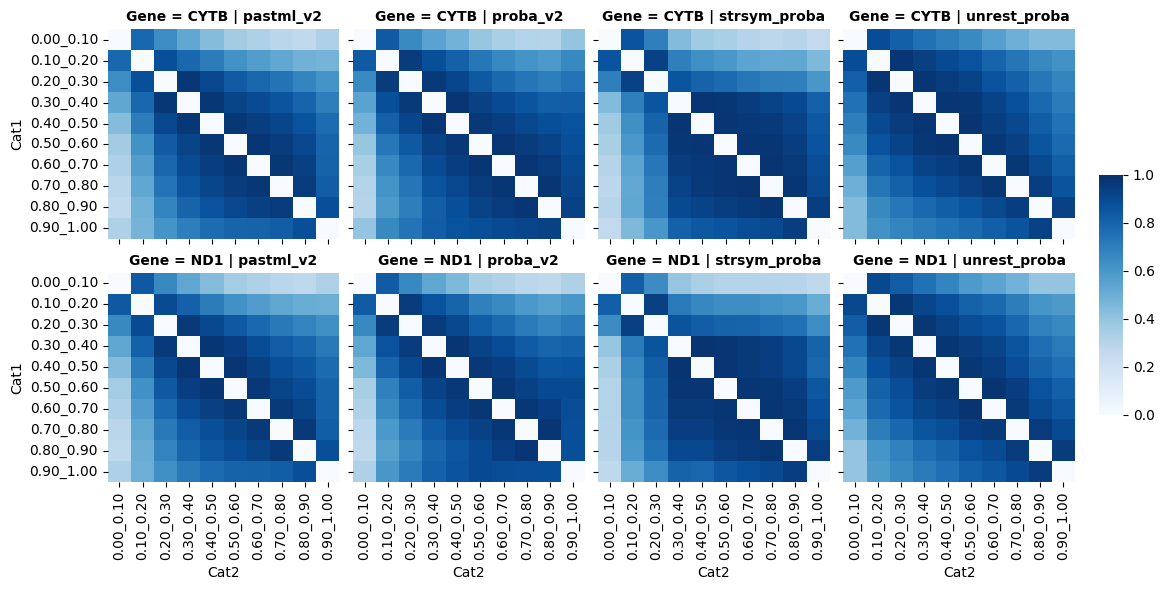

In [309]:
def facet_heatmap(data, color, **kws):
    data = data.pivot(index="Cat1", columns='Cat2', values='Sim')
    sns.heatmap(data, cmap='Blues', **kws)  # <-- Pass kwargs to heatmap

with sns.plotting_context(font_scale=5.5):
    g = sns.FacetGrid(sim_df_mean, row="Gene", col="Approach", size=3, aspect=1)

cbar_ax = g.fig.add_axes([.92, .3, .02, .4])  # <-- Create a colorbar axes

g = g.map_dataframe(facet_heatmap,
                    cbar_ax=cbar_ax,
                    vmin=0, vmax=1, )  # <-- Specify the colorbar axes and limits

g.set_titles(col_template="{col_name}", fontweight='bold', size=10)
g.fig.subplots_adjust(right=.9)  # <-- Add space so the colorbar doesn't overlap the plot
plt.show()

### Merged spectrum for full tree
Bad method

In [327]:
def assign_cat(p: float, interval=0.1):
    left = p // interval / 10
    right = left + interval
    return f"{left:.1f}_{right:.1f}"

In [328]:
mut_nd1["Cat"] = mut_nd1.ProbaFull.apply(assign_cat)
mut_cytb["Cat"] = mut_nd1.ProbaFull.apply(assign_cat)

In [326]:
freqs_mean = pd.concat([
    freqs_nd1[(freqs_nd1.Label == lbl) & (~freqs_nd1.Aproach.str.contains("simple"))].drop("Label", axis=1)\
              .assign(Gene="ND1").set_index(["Gene", "Aproach", "Node"]).mean(level=[0,1]),
    freqs_cytb[(freqs_cytb.Label == lbl) & (~freqs_cytb.Aproach.str.contains("simple"))].drop("Label", axis=1)\
               .assign(Gene="CYTB").set_index(["Gene", "Aproach", "Node"]).mean(level=[0,1]),
])[possible_sbs192]
freqs_mean

A[A>C]A  A[A>C]C  A[A>C]G  A[A>C]T    C[A>C]A    C[A>C]C  \
Gene Aproach                                                                  
ND1  strsym_proba      0.0      0.0      0.0      0.0  13.280685  10.119089   
     unrest_proba      0.0      0.0      0.0      0.0  11.527154   8.490058   
     proba_v2          0.0      0.0      0.0      0.0  12.719027   9.485722   
     pastml_v2         0.0      0.0      0.0      0.0  13.533498   9.752068   
CYTB strsym_proba      0.0      0.0      0.0      0.0  11.210285   6.858742   
     unrest_proba      0.0      0.0      0.0      0.0   9.922981   5.907197   
     proba_v2          0.0      0.0      0.0      0.0  10.863875   6.481020   
     pastml_v2         0.0      0.0      0.0      0.0  11.541223   6.874748   

                     C[A>C]G    C[A>C]T   G[A>C]A   G[A>C]C  ...   C[T>G]G  \
Gene Aproach                                                 ...             
ND1  strsym_proba   9.429810  10.230880  1.670049  1.997323  ...  1.446725   
     unrest_proba   8.821317   9.384316  1.517787  1.685508  ...  1.952499   
     proba_v2       9.452098  10.438284  1.569669  1.949811  ...  2.258378   
     pastml_v2      9.524027  11.175736  1.681468  1.887395  ...  2.282641   
CYTB strsym_proba  14.945701  13.770204  3.134061  3.373130  ...  1.752265   
     unrest_proba  13.651434  12.399337  2.717384  2.877056  ...  2.400105   
     proba_v2      14.638159  13.500678  2.963953  3.233310  ...  2.653754   
     pastml_v2     14.986118  14.199733  3.080081  3.166723  ...  2.707250   

                    C[T>G]T   G[T>G]A   G[T>G]C   G[T>G]G   G[T>G]T   T[T>G]A  \
Gene Aproach                                                                    
ND1  strsym_proba  1.508318  0.198409  0.288594  0.210158  0.270928  1.470090   
     unrest_proba  2.020472  0.257976  0.420276  0.248933  0.389531  1.963185   
     proba_v2      2.481739  0.315526  0.619990  0.284345  0.552110  2.217662   
     pastml_v2     2.607771  0.327029  0.621658  0.305552  0.560988  2.226176   
CYTB strsym_proba  1.660712  0.322019  0.263601  0.592229  0.452321  1.971328   
     unrest_proba  2.433802  0.470729  0.421121  0.728345  0.652592  2.831979   
     proba_v2      2.942959  0.570050  0.673063  0.817318  0.973605  3.148485   
     pastml_v2     3.070719  0.584662  0.667607  0.838789  0.917376  3.128412   

                    T[T>G]C   T[T>G]G   T[T>G]T  
Gene Aproach                                     
ND1  strsym_proba  1.329108  0.951039  0.943379  
     unrest_proba  1.794892  1.277997  1.225744  
     proba_v2      2.210254  1.359756  1.480085  
     pastml_v2     2.087561  1.290527  1.501248  
CYTB strsym_proba  2.003533  0.953465  0.785592  
     unrest_proba  3.062536  1.412646  1.147987  
     proba_v2      3.705543  1.549101  1.402232  
     pastml_v2     3.621609  1.404500  1.414438  

[8 rows x 192 columns]

In [332]:
nmuts_tree = pd.concat([
    mut_nd1[(mut_nd1.Label >= 1) & (mut_nd1.RefNode != "ROOT") & (~mut_nd1.Aproach.str.contains("simple"))]\
        .assign(Gene="ND1").groupby(["Gene", "Aproach", "Cat", "Mut"]).ProbaFull.sum().unstack().fillna(0.),
    mut_cytb[(mut_cytb.Label >= 1) & (mut_cytb.RefNode != "ROOT") & (~mut_cytb.Aproach.str.contains("simple"))]\
        .assign(Gene="CYTB").groupby(["Gene", "Aproach", "Cat", "Mut"]).ProbaFull.sum().unstack().fillna(0.)
])
for sbs in set(possible_sbs192).difference(nmuts_tree.columns):
    nmuts_tree[sbs] = 0.
nmuts_tree = nmuts_tree[possible_sbs192]

In [336]:
freqs_mean["Cat"] = freqs_mean["A[A>C]A"].apply(lambda x: nmuts_tree.index.levels[2].values)
freqs_mean = freqs_mean.explode("Cat").set_index("Cat", append=True)

In [338]:
idx = nmuts_tree.index.intersection(freqs_mean.index)
nmuts_tree = nmuts_tree.loc[idx]
freqs_mean = freqs_mean.loc[idx]

assert (freqs_mean.columns == nmuts_tree.columns).all()
assert (freqs_mean.index == nmuts_tree.index).all()

ava_spectras = (nmuts_tree / freqs_mean).fillna(0.)
ava_spectras = (ava_spectras.T / ava_spectras.T.sum(axis=0)).T

### Calculate similarities

In [339]:
sim_df_mean_raw = pd.DataFrame(spatial.distance.squareform(1 - spatial.distance.pdist(ava_spectras, "cosine")), index=ava_spectras.index, columns=ava_spectras.index)

In [340]:
print(sim_df_mean_raw.index.levels)

[['CYTB', 'ND1'], ['pastml_v2', 'proba_v2', 'strsym_proba', 'unrest_proba'], ['0.0_0.1', '0.1_0.2', '0.2_0.3', '0.3_0.4', '0.4_0.5', '0.5_0.6', '0.6_0.7', '0.7_0.8', '0.8_0.9', '0.9_1.0']]


In [341]:
data = []
for g in sim_df_mean_raw.index.levels[0]:
    for appr in sim_df_mean_raw.index.levels[1]:
        a = sim_df_mean_raw.loc[(g, appr), (g, appr)]
        a.index.rename("Cat1", inplace=True)
        a.columns.rename("Cat2", inplace=True)
        a = a.stack().rename("Sim").reset_index()
        a["Gene"] = g
        a["Approach"] = appr
        data.append(a)

sim_df_mean = pd.concat(data)
sim_df_mean.head()

,Cat1,Cat2,Sim,Gene,Approach
0,0.0_0.1,0.0_0.1,0.000000,CYTB,pastml_v2
1,0.0_0.1,0.1_0.2,0.997718,CYTB,pastml_v2
2,0.0_0.1,0.2_0.3,0.997208,CYTB,pastml_v2
3,0.0_0.1,0.3_0.4,0.990547,CYTB,pastml_v2
4,0.0_0.1,0.4_0.5,0.978879,CYTB,pastml_v2


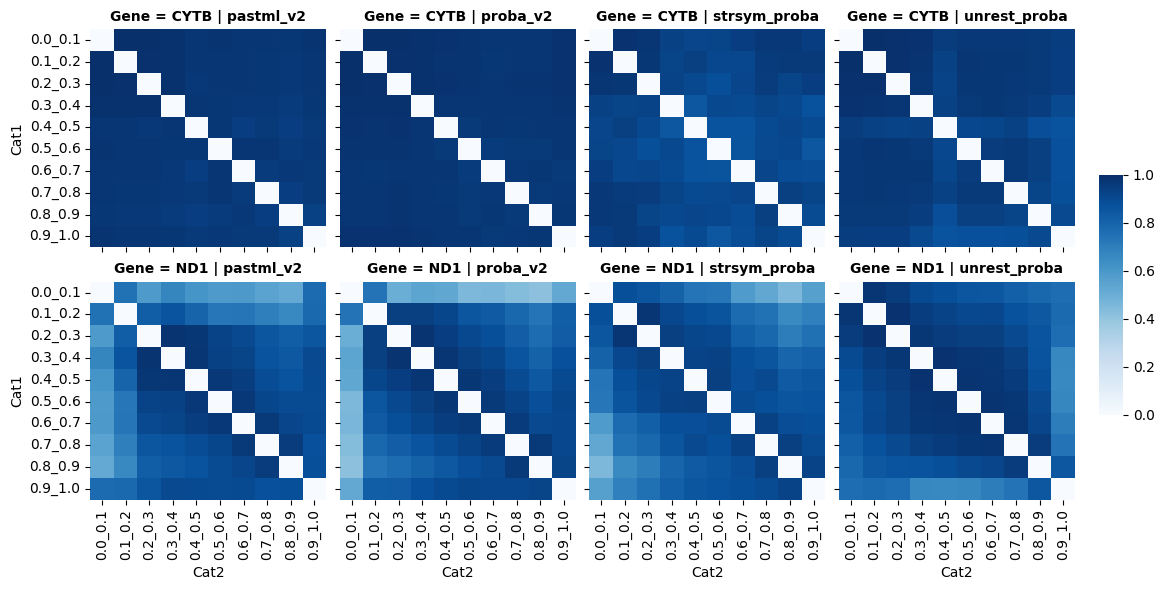

In [342]:
def facet_heatmap(data, color, **kws):
    data = data.pivot(index="Cat1", columns='Cat2', values='Sim')
    sns.heatmap(data, cmap='Blues', **kws)  # <-- Pass kwargs to heatmap

with sns.plotting_context(font_scale=5.5):
    g = sns.FacetGrid(sim_df_mean, row="Gene", col="Approach", size=3, aspect=1)

cbar_ax = g.fig.add_axes([.92, .3, .02, .4])  # <-- Create a colorbar axes

g = g.map_dataframe(facet_heatmap,
                    cbar_ax=cbar_ax,
                    vmin=0, vmax=1, )  # <-- Specify the colorbar axes and limits

g.set_titles(col_template="{col_name}", fontweight='bold', size=10)
g.fig.subplots_adjust(right=.9)  # <-- Add space so the colorbar doesn't overlap the plot
plt.show()